In [1]:
from dmeyf2025.modelling.train_model import train_models
from dmeyf2025.experiments.experiments import load_config
from dmeyf2025.etl import ETL
from dmeyf2025.processors.target_processor import BinaryTargetProcessor, CreateTargetProcessor
from dmeyf2025.processors.sampler import SamplerProcessor
from dmeyf2025.processors.feature_processors import DeltaLagTransformer
from dmeyf2025.metrics.revenue import lgb_gan_eval, revenue_from_prob
from run_experiment import get_features
import json
import os
import numpy as np
import lightgbm as lgb
import pandas as pd



/Users/frjofre/Documents/EyF/dmeyf2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
experiment_path = "experiments/V0.1.0/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6"

#params = json.load(open(os.path.join(experiment_path, "best_params.json")))
config = load_config(os.path.join(experiment_path, "config.yaml"))



In [3]:
train_months = config["data"]["train_months"]
eval_month = config["data"]["eval_month"]
positive_class = config["experiment"]["positive_classes"]
seeds = config["experiment"]["seeds"]
data_path = config["experiment"]["raw_data_path"]
sample_ratio = config["experiment"]["sample_ratio"]
test_months = 202105


# Processing

In [4]:
etl = ETL(data_path, CreateTargetProcessor(),
train_months = [202101, 202102, 202103, 202104, 202105, 202106],)
X, y, _,_,_,_ = etl.execute_complete_pipeline()
target_processor = BinaryTargetProcessor(positive_class)
X, y = target_processor.fit_transform(X, y)

16:22:34 | INFO | Iniciando pipeline ETL completo...
16:22:38 | INFO | Archivo leído exitosamente: 978439 filas, 155 columnas
16:22:41 | INFO | Procesamiento completado: 978439 filas, 155 columnas
16:22:42 | INFO | DataFrame train: 978439
16:22:42 | INFO | Pipeline ETL completado exitosamente!


In [5]:
X["target"] = y
X_transformed = get_features(X)
X_transformed.set_index("numero_de_cliente", inplace=True)


In [7]:
X_train = X_transformed[X_transformed["foto_mes"].isin(train_months)]
X_eval = X_transformed[X_transformed["foto_mes"].isin([eval_month])]
X_test = X_transformed[X_transformed["foto_mes"].isin([202105])] # Solo para ver el escalado
y_train = X_train["target"]
X_train = X_train.drop(columns=["target"])
X_eval = X_eval.drop(columns=["target"])

In [45]:
sampler_processor = SamplerProcessor(0.1, random_state=seeds[0])
X_train_sampled, y_train_sampled = sampler_processor.fit_transform(X_train, y_train)


16:51:41 | INFO | ✅ Dataset final: 71667 registros
16:51:41 | INFO |    - Clase positiva: 7385
16:51:41 | INFO |    - Clase negativa: 64282


# Train

In [46]:
#load hyperparams
params = json.load(open(os.path.join(experiment_path, "best_params.json")))
params["min_data_in_leaf"] = int(params["min_data_in_leaf"]/(len(X_train_sampled)/len(X_train)))


In [ ]:
cpayroll_pivot = X.pivot(index="numero_de_cliente", columns="foto_mes", values="cpayroll_trx")
# Calcula el salto entre 202106 y 202105
cpayroll_pivot["jump_202106_202105"] = cpayroll_pivot[202106] - cpayroll_pivot[202105]
# Selecciona clientes con salto de 1 o más
clientes_salto = cpayroll_pivot[cpayroll_pivot["jump_202106_202105"] >= 1].index.tolist()

factors = {"cpayroll_trx": 2, "mcuentas_saldo": 2, "mpayroll": 1.6, "mtransferencias_recibidas": 1.6, "cextraccion_autoservicio": 1.5}

X["target"] = y
X_transformed = get_features(X)
X_transformed.set_index("numero_de_cliente", inplace=True)

X_train = X_transformed[X_transformed["foto_mes"].isin(train_months)]
X_eval = X_transformed[X_transformed["foto_mes"].isin([eval_month])]
X_test = X_transformed[X_transformed["foto_mes"].isin([202105])] # Solo para ver el escalado
y_train = X_train["target"]
X_train = X_train.drop(columns=["target"])
X_eval = X_eval.drop(columns=["target"])



In [111]:
X_eval.loc[clientes_salto, factors.keys()]

,cpayroll_trx,mcuentas_saldo,mpayroll,mtransferencias_recibidas,cextraccion_autoservicio
numero_de_cliente,,,,,
249221323,2,8803.89,172011.06,0.00,0
249255456,2,1199470.89,444353.51,1249.24,4
249255747,3,195882.84,534317.98,593388.14,3
249275806,2,-1745.62,500672.76,295391.89,8
249321238,2,47048.84,111636.75,146329.40,1
...,...,...,...,...,...
1594878730,3,60546.02,241899.18,143994.13,7
1594946408,2,0.00,37536.00,18768.00,1
1594995417,3,21289.59,348322.35,0.00,10


In [117]:
X_eval.loc[clientes_salto, factors.keys()] = X_eval.loc[clientes_salto, factors.keys()] / factors.values()
X_eval.loc[clientes_salto, "cpayroll_trx"] = np.ceil(X_eval.loc[clientes_salto, "cpayroll_trx"])

X_eval.loc[clientes_salto, "cextraccion_autoservicio"] = np.ceil(X_eval.loc[clientes_salto, "cextraccion_autoservicio"])


In [10]:
preds, models= train_models(X_train, y_train, X_eval, params, seeds[:5], experiment_path)

16:26:25 | INFO | Training dataset shape: (650209, 786)
16:26:25 | INFO | Evaluating dataset shape: (164313, 786)
16:26:25 | INFO | Training final model with seed: 537919
16:27:09 | INFO | Training final model with seed: 923347
16:27:53 | INFO | Training final model with seed: 173629
16:28:37 | INFO | Training final model with seed: 419351
16:29:21 | INFO | Training final model with seed: 287887
16:30:04 | INFO | Training final model with seed: 41
16:30:47 | INFO | Training final model with seed: 42
16:31:31 | INFO | Training final model with seed: 43
16:32:14 | INFO | Training final model with seed: 44
16:32:59 | INFO | Training final model with seed: 45


In [119]:
from dmeyf2025.modelling.train_model import predict_ensemble_model
preds = predict_ensemble_model(models, X_eval)

In [122]:
config["experiment"]

{'commit': True,
 'data_path': './data',
 'debug': False,
 'description': 'Experimento Delta lags y percentiles, optimizando por ganancia, clase positiva durante training = (BAJA+1 y BAJA+2) Set de hiperparámetros B',
 'experiments_path': './experiments',
 'n_init': 30,
 'n_sends': 11500,
 'n_trials': 70,
 'name': 'delta-lags-percentile',
 'positive_classes': ['BAJA+1', 'BAJA+2'],
 'raw_data_path': './data/competencia_01_crudo.csv',
 'result_path': './results',
 'sample_ratio': 0.1,
 'seeds': [537919, 923347, 173629, 419351, 287887, 41, 42, 43, 44, 45],
 'tag': '0.1_150_01-04_G_Base',
 'version': '0.0.6'}

In [124]:
from dmeyf2025.modelling.train_model import prob_to_sends

experiment_path = "experiments/V0.1.0"
experiment_folder = "delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6"
config["experiment"]["experiment_folder"] = experiment_folder
config["experiment"]["experiments_path"] = experiment_path
preds = prob_to_sends(config["experiment"], preds, 10000, "factors")



In [127]:
comun = pd.read_csv("experiments/V0.1.0/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6_ensemble_predictions.csv")
hp_escaled = pd.read_csv("experiments/V0.1.0/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6_ensemble_predictions_hpscaled.csv")
factors = pd.read_csv("experiments/V0.1.0/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6_factors.csv")

In [129]:
comun.set_index("numero_de_cliente", inplace=True)
hp_escaled.set_index("numero_de_cliente", inplace=True)
factors.set_index("numero_de_cliente", inplace=True)
comun.index.name = "numero_de_cliente"
hp_escaled.index.name = "numero_de_cliente"
factors.index.name = "numero_de_cliente"


In [146]:
(comun & hp_escaled & factors).reset_index().to_csv("experiments/V0.1.0/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6_multiensemble_and.csv", index=False)

In [147]:
(comun | hp_escaled | factors).reset_index().to_csv("experiments/V0.1.0/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6_multiensemble_or.csv", index=False)

In [160]:
print((comun | hp_escaled | factors).sum())

predicted    12858
dtype: int64


In [162]:
print((comun & hp_escaled & factors).sum())

predicted    9383
dtype: int64


In [166]:
((comun + hp_escaled + factors)["predicted"] > 1).astype(int).reset_index().to_csv("experiments/V0.1.0/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6_multiensemble_voting.csv", index=False)

In [132]:
predictions = pd.merge(comun, hp_escaled, on="numero_de_cliente", how="left")

In [139]:
(pd.merge(predictions, factors, on="numero_de_cliente", how="left").sum(axis=1) >= 1).sum()

np.int64(12858)

# Features

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

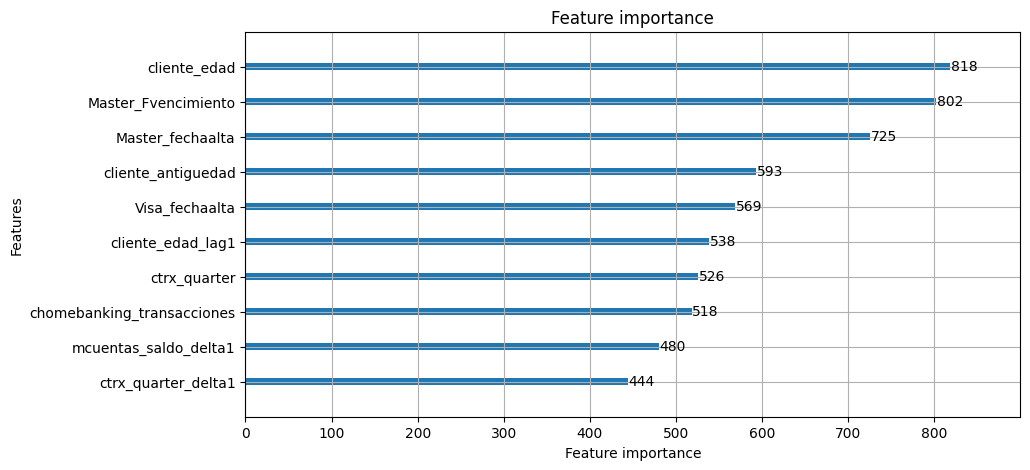

In [11]:
model  = models[0]
lgb.plot_importance(model, importance_type="split", max_num_features=10, figsize=(10, 5))



In [12]:
importances = pd.DataFrame()
importances["feature"] = X_train.columns
for n, model in enumerate(models):
    importances[f"importance_{n}"] = model.feature_importance(importance_type="gain")

In [13]:
importances["importance_mean"] = importances.drop(columns=["feature"]).mean(axis=1)
importances.sort_values(by="importance_mean", ascending=False, inplace=True)
importances.head(20)

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance_5,importance_6,importance_7,importance_8,importance_9,importance_mean
106,ctrx_quarter,198315.248775,202438.411993,177361.627120,181014.094350,184953.631256,206491.897409,199253.169562,199994.856412,170845.495011,184579.396754,190524.782864
50,cpayroll_trx,26673.191680,28083.320901,30766.836052,29610.101874,30308.281942,27347.590153,28269.822145,29364.479712,35643.264342,29887.731080,29595.461988
32,mprestamos_personales,26624.343727,28924.495353,27716.350124,27048.667166,29370.548051,28079.666615,28336.459834,28192.543910,29941.540331,28511.409169,28274.602428
10,mpasivos_margen,19854.197802,17057.063308,21785.498764,17695.356972,19901.550725,17358.403683,18289.593364,18025.462513,23687.117161,24285.015873,19793.926016
723,mcuentas_saldo_percentile,10120.768311,19803.098802,16942.527747,16629.434462,20336.608006,19427.440003,15407.260745,20739.045023,16704.363772,21313.054283,17742.360115
735,mpayroll_percentile,23847.706777,16691.827876,9760.066504,20131.439170,8525.896728,14066.495106,22711.937810,13286.476236,17811.143901,20274.589438,16710.757955
51,mpayroll,8881.880148,13625.005273,18975.663506,11640.711938,20816.423575,16405.536620,8641.427082,17243.085211,13308.559767,11271.992119,14081.028524
21,mcuentas_saldo,18305.354161,9669.587753,12887.777606,12209.499648,7545.439571,10015.784569,14031.689914,8744.913704,12678.442498,7600.769999,11368.925942
720,mcaja_ahorro_percentile,7915.591678,8865.853061,9055.449745,7070.030161,15190.424095,9482.805734,9361.253568,7626.709835,12099.737823,12966.734789,9963.459049
132,Visa_status,8579.700976,8886.765635,9686.475792,9197.223110,8608.160723,8631.553675,8734.283650,8729.154213,8644.180160,8638.250872,8833.574881


In [25]:
c = list(X_train.columns[X_train.columns.str.contains("cpayroll_trx")]) + ["target", "foto_mes"]

In [31]:
X_train["target"] = y_train
X_train[X_train["foto_mes"] > 202101][c].groupby(["foto_mes", "target"]).mean()

cpayroll_trx  cpayroll_trx_lag1  cpayroll_trx_lag2  \
foto_mes target                                                       
202102   0           0.887143           0.949320                NaN   
         1           0.099839           0.096809                NaN   
202103   0           0.961631           0.891639           0.954141   
         1           0.120101           0.116667           0.119023   
202104   0           0.915554           0.967412           0.896948   
         1           0.092086           0.133365           0.134205   

                 cpayroll_trx_delta1  cpayroll_trx_delta2  
foto_mes target                                            
202102   0                 -0.063261                  NaN  
         1                  0.002704                  NaN  
202103   0                  0.068203             0.004364  
         1                  0.003030            -0.001526  
202104   0                 -0.053276             0.015610  
         1                 -0.041887            -0.043605

In [39]:
c = list(X_train.columns[X_train.columns.str.contains("cpayroll_trx")]) + ["foto_mes"]
X_eval[c].groupby(["foto_mes"]).mean()

,cpayroll_trx,cpayroll_trx_lag1,cpayroll_trx_lag2,cpayroll_trx_delta1,cpayroll_trx_delta2
foto_mes,,,,,
202106,1.250668,0.973892,0.91552,0.274101,0.329106


In [ ]:
cpayroll_pivot = X.pivot(index="numero_de_cliente", columns="foto_mes", values="cpayroll_trx")
# Calcula el salto entre 202106 y 202105
cpayroll_pivot["jump_202106_202105"] = cpayroll_pivot[202106] - cpayroll_pivot[202105]
# Selecciona clientes con salto de 1 o más
clientes_salto = cpayroll_pivot[cpayroll_pivot["jump_202106_202105"] >= 1].index.tolist()

In [ ]:
features = list(importances["feature"])
filtered_features = [f.replace("_percentile", "") for f in features if "lag" not in f and "delta" not in f]

['ctrx_quarter',
 'cpayroll_trx',
 'mprestamos_personales',
 'mpasivos_margen',
 'mcuentas_saldo',
 'mpayroll',
 'mpayroll',
 'mcuentas_saldo',
 'mcaja_ahorro',
 'Visa_status',
 'mpasivos_margen',
 'cdescubierto_preacordado',
 'mtarjeta_visa_consumo',
 'Master_fechaalta',
 'cliente_edad',
 'Visa_fechaalta',
 'Master_Fvencimiento',
 'mcaja_ahorro',
 'ctarjeta_visa_transacciones',
 'mprestamos_personales',
 'mactivos_margen',
 'chomebanking_transacciones',
 'mactivos_margen',
 'cliente_antiguedad',
 'mrentabilidad_annual',
 'Visa_msaldopesos',
 'Visa_msaldototal',
 'Master_status',
 'mcuenta_corriente',
 'mrentabilidad_annual',
 'Visa_mpagominimo',
 'Visa_msaldopesos',
 'mtarjeta_visa_consumo',
 'cproductos',
 'mcuenta_corriente',
 'ctarjeta_master',
 'Master_mfinanciacion_limite',
 'internet',
 'Visa_Fvencimiento',
 'ccaja_seguridad',
 'Visa_mfinanciacion_limite',
 'ccomisiones_otras',
 'ccaja_ahorro',
 'mrentabilidad',
 'tmobile_app',
 'Visa_cconsumos',
 'Visa_mpagominimo',
 'tcallcent

In [104]:
aguinaldo = X[X["numero_de_cliente"].isin(clientes_salto)].groupby(["foto_mes"])[filtered_features].median().iloc[-1] / X[X["numero_de_cliente"].isin(clientes_salto)].groupby(["foto_mes"])[filtered_features].median().iloc[-2]

In [105]:
aguinaldo[(aguinaldo.values > 1.45) & (aguinaldo.values < 5)]

cpayroll_trx                 2.000000
mcuentas_saldo               2.010433
mpayroll                     1.611688
mpayroll                     1.611688
mcuentas_saldo               2.010433
mtransferencias_recibidas    1.597849
mtransferencias_recibidas    1.597849
cextraccion_autoservicio     1.500000
dtype: float64

In [ ]:
factors = {"cpayroll_trx": 2, "mcuentas_saldo": 2, "mpayroll": 1.6, "mtransferencias_recibidas": 1.6, "cextraccion_autoservicio": 1.5}

# Predict

In [ ]:
import numpy as np
ones = np.ones(10000, dtype=int)
zeros = np.zeros(len(preds)-10000, dtype=int)
predictions = np.concatenate([ones, zeros])

In [ ]:
ones = np.ones(10000, dtype=int)
zeros = np.zeros(len(preds)-10000, dtype=int)
predictions = np.concatenate([ones, zeros])
preds["predicted"] = predictions
preds[["numero_de_cliente", "predicted"]].to_csv(f"{experiment_path}/DeltaLags2_0.3_150_01-04_G_0.0.2_ensemble_10k_predictions.csv", index=False)